# Assignment 01

This assignment consists of two tasks with subtasks. Every subtask has a point value and lists expectations for answers. Please read both task and expectations carefully before answering.

### Hand-in Instructions

Submit a single `.ipynb` file with all outputs saved. The notebook must be fully self-contained and ready to read without running any cells.

### Overview

| Task  | Topic                                     | Points  |
| ----- | ----------------------------------------- | ------- |
| **1** | **PCA**                                   |         |
| 1.1   | 3D scatter plot                           | 5       |
| 1.2   | 2D scatter plot                           | 5       |
| 1.3   | Interpreting variance                     | 10      |
| 1.4   | Variance and geometry                     | 10      |
| **2** | **Breast Cancer Classification Pipeline** |         |
| 2.1   | Exploratory Data Analysis                 | 30      |
| 2.2   | Train/Test Split                          | 5       |
| 2.3   | Baseline Model                            | 5       |
| 2.4   | Kitchen Sink Model                        | 10      |
| 2.5   | Build Your Own Pipeline                   | 20      |
|       | **Total**                                 | **100** |


---

## Setup


In [99]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.datasets import load_breast_cancer

from sklearn.ensemble import RandomForestClassifier


from assignment_utils import generate_annulus_4d

---

## Task 1: PCA

You've been given a mysterious dataset with **4 dimensions** (F1, F2, F3, F4). We can't directly visualize 4D data, but we can look at 3 dimensions at a time and use color for the 4th.


In [100]:
data_4d, radius = generate_annulus_4d()
df = pd.DataFrame(data_4d, columns=["F1", "F2", "F3", "F4"])
print(f"Dataset shape: {df.shape}")

# Let's visualize the first 3 dimensions (F1, F2, F3) in 3D
# The 4th dimension (F4) is represented as color
fig = px.scatter_3d(
    df,
    x="F1",
    y="F2",
    z="F3",
    color=df["F4"],
    color_continuous_scale="viridis",
    title="3D View of the 4D Dataset (F1, F2, F3, color=F4)",
    labels={"color": "F4"},
)
fig.update_traces(marker=dict(size=3))
fig.update_layout(width=800, height=600)
fig.show()

Dataset shape: (1500, 4)


### Principal Component Analysis (PCA)

**PCA** is a technique that finds new axes (called _principal components_) that capture the most variance in the data.

**Mathematical formulation:**

1. **Standardize** the data: $\mathbf{Z} = \frac{\mathbf{X} - \boldsymbol{\mu}}{\boldsymbol{\sigma}}$

2. Compute the **covariance matrix**: $\mathbf{C} = \frac{1}{n-1} \mathbf{Z}^T \mathbf{Z}$

3. Find the **eigenvectors** and **eigenvalues** of $\mathbf{C}$:
   $$\mathbf{C} \mathbf{v}_i = \lambda_i \mathbf{v}_i$$
4. **Project** the data onto the principal components: $\mathbf{Z}_{PC} = \mathbf{Z} \mathbf{V}$

where $\mathbf{V} = [\mathbf{v}_1, \mathbf{v}_2, \ldots]$ are the eigenvectors sorted by decreasing eigenvalue $\lambda_i$.

**Key ideas:**

- **PC1** points in the direction of maximum variance (largest $\lambda$)
- **PC2** is perpendicular to PC1 and captures the next most variance
- The **explained variance ratio** for each PC is: $\frac{\lambda_i}{\sum_j \lambda_j}$
- The eigenvectors $\mathbf{V} = [\mathbf{v}_1, \mathbf{v}_2, \ldots]$ are basis vectors for the principal component space. Any data vector can be completely reconstructed by a linear combination of these principal component basis vectors.

If the data lies on a lower-dimensional subspace, PCA can reveal it by finding the directions that matter most.

Let's standardize the data first (so all features have equal scale), then apply PCA.


In [101]:
# Standardize and apply PCA
scaler = StandardScaler()
data_scaled = scaler.fit_transform(df)

pca = PCA()
data_pca = pca.fit_transform(data_scaled)

# Create a DataFrame with principal components
df_pca = pd.DataFrame(data_pca, columns=["PC1", "PC2", "PC3", "PC4"])
print("Explained variance ratio:", pca.explained_variance_ratio_)
print("Cumulative explained variance ratio:", np.cumsum(pca.explained_variance_ratio_))

# Get the PC directions (loadings) - each row is a PC, each column is a feature
components = pca.components_  # Shape: (4, 4) - 4 PCs x 4 features

# Create the scatter plot of scaled data (first 3 features)
fig = go.Figure()

# Add the data points
fig.add_trace(
    go.Scatter3d(
        x=data_scaled[:, 0],
        y=data_scaled[:, 1],
        z=data_scaled[:, 2],
        mode="markers",
        marker=dict(size=2, opacity=0.5),
        name="Data",
    )
)

# Add arrows for PC1, PC2, PC3 directions
# Arrow length proportional to explained variance ratio (with minimum for visibility)
colors = ["red", "green", "blue"]
base_scale = 5  # Base scale factor
min_scale = 0.5  # Minimum scale so small PCs are still visible

for i in range(3):
    pc_direction = components[i, :3]  # First 3 components of each PC
    # Scale by explained variance ratio - longer arrow = more variance
    # Use minimum scale so all arrows are visible
    variance_ratio = pca.explained_variance_ratio_[i] / max(
        pca.explained_variance_ratio_
    )
    scale = max(base_scale * variance_ratio, min_scale)

    # Arrow line
    fig.add_trace(
        go.Scatter3d(
            x=[0, pc_direction[0] * scale],
            y=[0, pc_direction[1] * scale],
            z=[0, pc_direction[2] * scale],
            mode="lines",
            line=dict(color=colors[i], width=8),
            name=f"PC{i + 1} ({pca.explained_variance_ratio_[i]:.1%} var)",
        )
    )

    # Arrow head (cone)
    fig.add_trace(
        go.Cone(
            x=[pc_direction[0] * scale],
            y=[pc_direction[1] * scale],
            z=[pc_direction[2] * scale],
            u=[pc_direction[0]],
            v=[pc_direction[1]],
            w=[pc_direction[2]],
            colorscale=[[0, colors[i]], [1, colors[i]]],
            showscale=False,
            sizemode="absolute",
            sizeref=0.3,
        )
    )

fig.update_layout(
    title="Principal Component Directions (arrow length ∝ variance explained)",
    scene=dict(
        xaxis_title="F1 (scaled)",
        yaxis_title="F2 (scaled)",
        zaxis_title="F3 (scaled)",
    ),
    width=800,
    height=600,
)
fig.show()

Explained variance ratio: [5.08608377e-01 4.90832830e-01 5.58792885e-04 3.76671713e-17]
Cumulative explained variance ratio: [0.50860838 0.99944121 1.         1.        ]


### Task 1.1 3D scatter plot

- Task: Create a 3D scatter plot using PC1, PC2, PC3 as axes
- Points: 5
- Expectations: A working 3D scatter plot of the PCA-transformed data (similar in style to the first 3D plot). No further analysis or comments.


In [102]:
fig_pca = px.scatter_3d(
    df_pca,
    x="PC1",
    y="PC2",
    z="PC3",
    title="3D View in PCA Space (PC1, PC2, PC3)",
    labels={
        "PC1": "PC1 (standardized units)",
        "PC2": "PC2 (standardized units)",
        "PC3": "PC3 (standardized units)",
    },
    # No colour mapping PC4 is is noise
)

evr = pca.explained_variance_ratio_

fig_pca.update_traces(marker=dict(size=3))

fig_pca.update_layout(
    scene=dict(
        xaxis_title=f"PC1 ({evr[0]:.1%} variance)",
        yaxis_title=f"PC2 ({evr[1]:.1%} variance)",
        zaxis_title=f"PC3 ({evr[2]:.1%} variance)",
        aspectmode="data",  # Fixes ratio
    ),
    width=800,
    height=600,
)
fig_pca.show()

If you use auto scaling, the figure will look like a cylinder, but this would be misleading and not represent the relationship between PC1, PC2, and PC3. The auto scaling stretches one axis disproportionately, distorting the true geometry of the data.

Therefore we use:
```Python
aspectmode="data",  # Fixes ratio
```

This ensures that equal distances on all three axes are represented equally, preserving the true proportions of the data.

### Task 1.2 2D scatter plot

- Task: Create a 2D scatter plot using PC1, PC2 as axes
- Points: 5
- Expectations: A working 2D scatter plot of the PCA-transformed data. No further analysis or comments.


In [103]:
fig_pca = px.scatter(
    df_pca,
    x="PC1",
    y="PC2",
    title="2D View in PCA Space (PC1, PC2)",
    labels={
        "PC1": "PC1 (standardized units)",
        "PC2": "PC2 (standardized units)",
    },
    # No colour mapping PC4 is is noise
)

evr = pca.explained_variance_ratio_

fig_pca.update_traces(marker=dict(size=3))

fig_pca.update_layout(
    xaxis_title=f"PC1 ({evr[0]:.1%} variance)",
    yaxis_title=f"PC2 ({evr[1]:.1%} variance)",
    width=800,
    height=600,
)
fig_pca.show()


### Task 1.3 Interpreting variance

- Task: How much variance do PC1 and PC2 capture together? Based on this, what can you conclude about the original 4D dataset?
- Points: 10
- Expectations: A written response (1 paragraph).




#### Svar

In [104]:
pc1_var = pca.explained_variance_ratio_[0]
pc2_var = pca.explained_variance_ratio_[1]
pc1_pc2_var = pc1_var + pc2_var

print(f"PC1 explained variance: {pc1_var:.1%}")
print(f"PC2 explained variance: {pc2_var:.1%}")
print(f"PC1 + PC2 together: {pc1_pc2_var:.1%}")

PC1 explained variance: 50.9%
PC2 explained variance: 49.1%
PC1 + PC2 together: 99.9%


PC1 and PC2 together capture 99.9% of the total variance in the dataset, where PC1 explains 50.9% and PC2 explains 49.1%. This high cumulative variance ratio shows that the 4-dimensional dataset is in practice **2-dimensional**, the data lies almost entirely on a 2D subspace within the 4-dimensional space. Although we have 4 measured variables, the structure of the data can be represented nearly perfectly with just 2 principal components. The two remaining dimensions (PC3 and PC4) contribute minimally to the variation. The PCA analysis thus reveals a hidden low-dimensional pattern in the data and can be used in further data analysis.

### Task 1.4 Variance and geometry

- Task: If PC1 explained 90% of the variance and PC2 only 10%, what shape would you expect the data to form? Now compare this to your actual ~50/50 split — what does this tell you about the geometry of your data?
- Points: 10
- Expectations: A written response (1 paragraph).


#### Answer

If PC1 explained 90% and PC2 only 10%, the data would form an **elongated, line-like structure** that stretches along one direction with minimal spread perpendicular to it. The actual ~50/50 distribution, however, shows that the data spreads **equally in two perpendicular directions**, which creates a **circular or ring-shaped geometry**. This symmetric distribution means that both principal components contribute approximately equally to describing the data structure, in contrast to the 90/10 scenario where one axis dominates. The nearly equal variance distribution reveals that the underlying geometry is balanced and symmetric in 2D, without one dominant axis, as we see with the ring shape. This comparison illustrates how the variance ratio directly reflects geometric properties: unequal distributions produce elongated or oval shapes, while equal distributions produce symmetric circular structures.

---

## Task 2: Breast Cancer Classification Pipeline

Now let's apply what you've learned to a real-world dataset: the **Wisconsin Breast Cancer** dataset. This dataset contains measurements from cell nuclei in breast tissue samples, and the goal is to classify tumors as **malignant** or **benign**.

**Sources:**

- [sklearn.datasets.load_breast_cancer](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_breast_cancer.html)
- [UCI Machine Learning Repository](https://archive.ics.uci.edu/dataset/17/breast+cancer+wisconsin+diagnostic)

We'll work through a complete machine learning workflow:

1. Exploratory Data Analysis (EDA)
2. Train/test split
3. Baseline model
4. "Kitchen sink" model (all features, no preprocessing)
5. Build your own pipeline


In [105]:
# Load the breast cancer dataset
cancer = load_breast_cancer()
df_cancer = pd.DataFrame(cancer.data, columns=cancer.feature_names)
df_cancer["target"] = cancer.target

print(f"Dataset shape: {df_cancer.shape}")
print(f"Target classes: {cancer.target_names}")

Dataset shape: (569, 31)
Target classes: ['malignant' 'benign']


### Task 2.1 Exploratory Data Analysis (EDA)

- Task: Conduct an EDA of the breast cancer dataset. For each analysis you perform, explain _why_ you chose to look at it and what it tells you.
- Points: 30
- Expectations: A mix of code, plots, and written commentary. Quality of reasoning and plots matters more than quantity of plots.


The first thing we can do is to check if there is any missing data in the dataset. It is not:

In [106]:
print(df_cancer.isnull().values.any()) #Ser etter NULL-verdier i datasettet.

False


In addition we make a correlation heatmap, to visualizing which data has a high correlation factor with test.

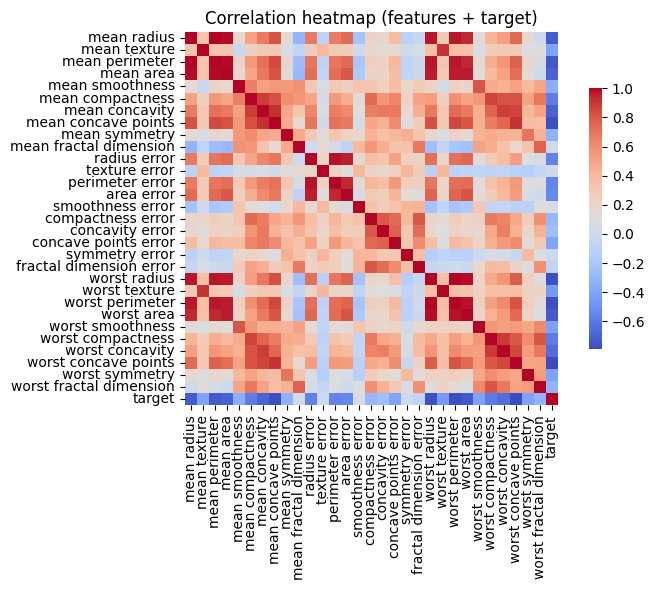

target                  1.000000
worst concave points    0.793566
worst perimeter         0.782914
mean concave points     0.776614
worst radius            0.776454
mean perimeter          0.742636
worst area              0.733825
mean radius             0.730029
mean area               0.708984
mean concavity          0.696360
Name: target, dtype: float64


In [107]:
corr_matrix = df_cancer.corr()
plt.figure(figsize=(8, 6))

sns.heatmap(
    corr_matrix,
    annot=False,
    fmt=".2f",
    cmap="coolwarm",
    square=True,
    cbar_kws={"shrink": 0.7},
)

plt.title("Correlation heatmap (features + target)")
plt.tight_layout()
plt.show()

abs_corr_target = corr_matrix["target"].abs().sort_values(ascending=False)

abs_corr_target_10 = abs_corr_target.head(10)

print(abs_corr_target_10)

We now see that worst **concave points**, **worst perimeter**, and **mean concave** points are the three variables with the highest correlation to **target**. By identifying the highest correlation with **target**, we determine which variables create the greatest distinction between malignant and benign cases. One can also use the generated matrix to identify which features have the lowest correlation with each other. It is not desirable to have too high correlation between features, as this provides little added value and will most likely just form a line or a curve. 

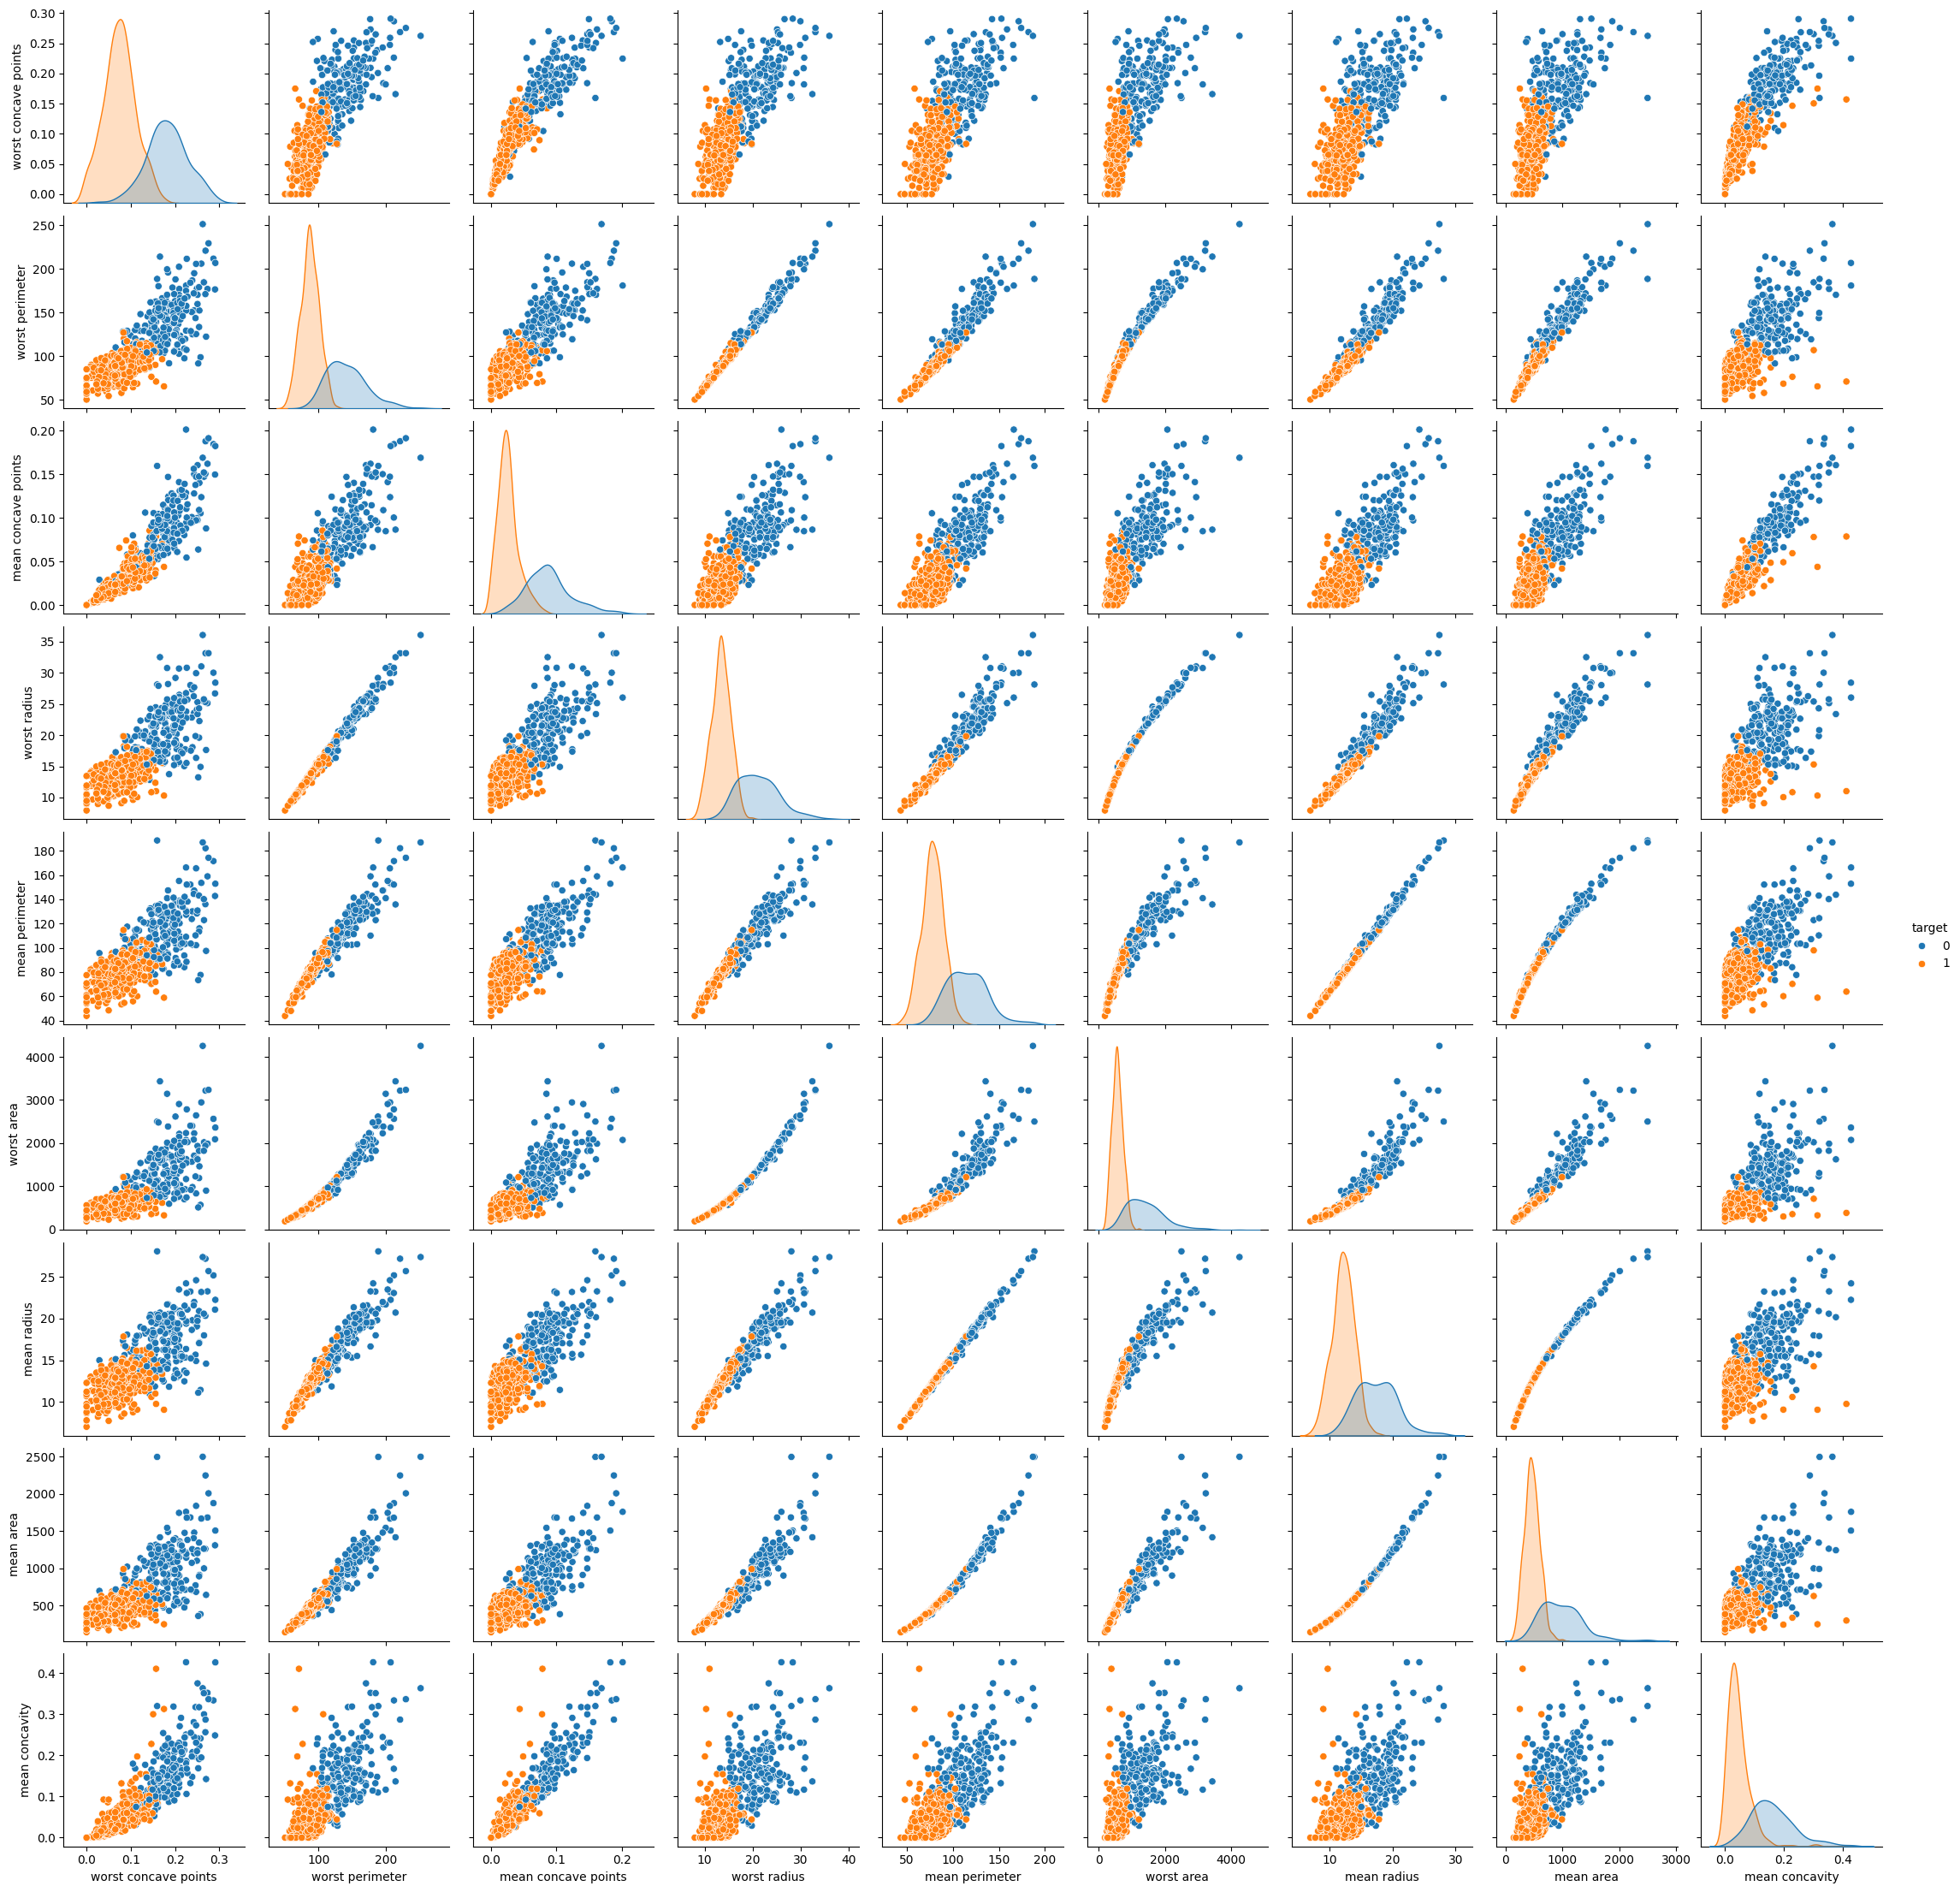

In [108]:
sns.pairplot(df_cancer[abs_corr_target_10.index], hue="target")

Next, we must determine which combination of features makes it easiest to identify whether a case is malignant or benign. If we compare the two figures we obtained, we see that high correlation between two features leads to a more linear relationship. This is not desirable, as it removes a dimension from the measurement. By first selecting values that overlap with test, we can use those to select which data points are positive. But since there isn't a single data point which overlaps/correlates 100% we need to have more in order to distinguish the data. But when selecting these features it's important that they correlate to eachother as seen with worst radius and worst area. These values correlate both on the heatmap, and intuitively. Therefore we only need to choose one of them.

It is also important to consider that a false negative is worse than a false positive. Therefore, one can examine the graphs and determine which plots are best suited to achieve the fewest possible errors and to reduce misclassifications to nearly zero for false negatives.

We therefore manually select, based on the graphs, what we consider to be the best solution. **Worst area** and **worst concave points** appear to provide the strongest separation as well as correlation with the target and will thus be rated highest based on our human evaluation.


It is also possible to use AI to carry out the EDA process. To do this, one can use the **RandomForestClassifier** function, which performs the process for you. This can be useful for comparing the results with what you arrive at yourself.
The random forest code section is attached below.

In [109]:
X = df_cancer.drop("target", axis=1)
y = df_cancer["target"]

rf = RandomForestClassifier(random_state=42)
rf.fit(X, y)

importances = pd.Series(rf.feature_importances_, index=X.columns)
importance_10 = importances.sort_values(ascending=False).head(10)
print(importance_10)
importance_10_ind = importance_10.index

worst area              0.139357
worst concave points    0.132225
mean concave points     0.107046
worst radius            0.082848
worst perimeter         0.080850
mean perimeter          0.067990
mean concavity          0.066917
mean area               0.060462
worst concavity         0.037339
mean radius             0.034843
dtype: float64


With **RandomForestClassifier**, we confirmed the assumption that **worst area** and **worst concave points** are good parameters for determining **target**'s value.

After looking at the different results that containes two features we tried to add a third feature to get more distance between "malignant" and "benign". This is done with the code underneath:

In [110]:
#3D scatter plot med tre features
fig = go.Figure()

#Definerer features
x = "worst concave points"
y = "mean concave points"
z = "worst area"


# Legger til malignant samples
malignant_samples = df_cancer[df_cancer["target"]==0]
fig.add_trace(
    go.Scatter3d(
        x=malignant_samples[x],
        y=malignant_samples[y],
        z=malignant_samples[z],
        mode="markers",
        marker=dict(size=4, color="#2E86AB", line=dict(width=1, color="black")),
        name="Maligant",
    )
)


# legger til benign samples
benign_samples = df_cancer[df_cancer["target"]==1]
fig.add_trace(
    go.Scatter3d(
        x=benign_samples[x],
        y=benign_samples[y],
        z=benign_samples[z],
        mode="markers",
        marker=dict(size=4, color="#A23B72", line=dict(width=1, color="black")),
        name="Benign",
    )
)

#Lager figur layout
fig.update_layout(
    title="3D Feature Space:",
    scene=dict(
        xaxis_title=x,
        yaxis_title=y,
        zaxis_title=z,
        xaxis=dict(range=[df_cancer[x].min(), df_cancer[x].max()]), #Sørgeer for at aksene skaleres basert på dataen
        yaxis=dict(range=[df_cancer[y].min(), df_cancer[y].max()]),
        zaxis=dict(range=[df_cancer[z].min(), df_cancer[z].max()]),
    ),
    font=dict(size=12),
)

#Viser figur
fig.show()


As seen in this example (and if we try with other features that corresponds good with the target), adding another dimension does not do much with the result that we as humans can see. That does not mean that a computer can't see any difference.

### Task 2.2 Train/Test Split

- Task: Split the data into training and test sets (80/20) before any modeling.
- Points: 5
- Expectations: Complete the TODO line to create an 80/20 split with `random_state=42` for reproducibility.


In [111]:
# Separate features and target
X = df_cancer.drop("target", axis=1)
y = df_cancer["target"]

# Split into train/test sets (80/20 split with random_state=42)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")
print(f"Total size: {X_train.shape[0] + X_test.shape[0]}")

Training set size: 455
Test set size: 114
Total size: 569


### Task 2.3 Baseline Model

Before building a real model, it's wise to establish a **baseline** — a classifier that any real model should beat.

A **confusion matrix** shows how predictions compare to actual labels:

|                     | Predicted Negative  | Predicted Positive  |
| ------------------- | ------------------- | ------------------- |
| **Actual Negative** | TN (True Negative)  | FP (False Positive) |
| **Actual Positive** | FN (False Negative) | TP (True Positive)  |

For cancer diagnosis: FN means missing a malignant tumor (bad!), FP means a false alarm (less bad, but still costly).

- Task: Run the code below, note the accuracy and examine the confusion matrix. Describe what this classifier does. Would you trust it for diagnosis? Why or why not?
- Points: 5
- Expectations: A written response (1 paragraph).


Baseline accuracy: 0.623


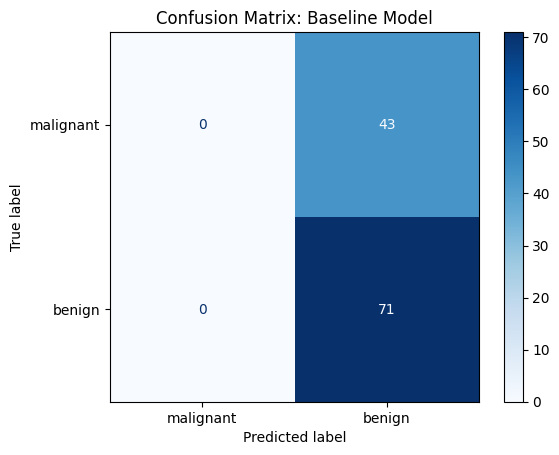

In [112]:
dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(X_train, y_train)

baseline_accuracy = dummy.score(X_test, y_test)
print(f"Baseline accuracy: {baseline_accuracy:.3f}")

ConfusionMatrixDisplay.from_estimator(
    dummy, X_test, y_test, display_labels=cancer.target_names, cmap="Blues"
)
plt.title("Confusion Matrix: Baseline Model")
plt.show()

#### Answer 

We can see that this baseline classifier chooses the answer that gives the most correct predictions, in other words, a “most frequent” strategy. Since benign is the most common class in the dataset, this model will be most accurate if it always predicts that the outcome will be benign. From the confusion matrix, we see that the model always predicts “benign” (benign tumors) and never predicts “malignant” (malignant tumors). This is confirmed by the fact that all predictions fall into the “Predicted benign” column, while the “Predicted malignant” column is completely empty.

Although the model achieves an accuracy of around 62–63%, I would absolutely not trust it for cancer diagnosis. The reason is that the model fails to identify all (100%) cancer cases. In a medical context, this is catastrophic, because the consequences of failing to detect cancer (false negatives) are far more serious than false alarms (false positives).

Such a classifier is only useful as a baseline for comparison; any learning-based model should easily be able to perform better than this naive approach. The accuracy of approximately 63% really just reflects that the majority of samples in the dataset are benign and provides no real diagnostic value.



### Task 2.4 Kitchen Sink Model

The "kitchen sink" approach: throw all features into the model without any preprocessing. Let's see what happens.

**Logistic Regression** is a linear classifier that predicts the probability of a binary outcome. It models:

$$P(y=1 | \mathbf{x}) = \sigma(\mathbf{w}^T \mathbf{x} + b) = \frac{1}{1 + e^{-(\mathbf{w}^T \mathbf{x} + b)}}$$

where $\sigma$ is the sigmoid function, $\mathbf{w}$ are the feature weights, and $b$ is the bias. The model is trained by minimizing the logistic loss using an iterative optimizer. Here we use **SAGA** (`solver="saga"`), a stochastic gradient method whose fast convergence is only guaranteed on features with approximately the same scale ([sklearn docs](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)).

- Task: Run the code below. Did the model converge? Why or why not? Explain based on your EDA findings and how gradient-based optimization works.
- Points: 10
- Expectations: A written response (1 paragraph).


Kitchen sink train accuracy: 0.899
Kitchen sink test accuracy:  0.947


/home/eskil/cisk/ing3513/course-materials/.venv/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



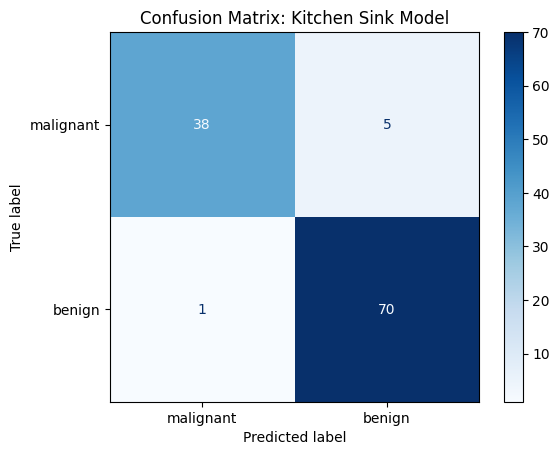

In [113]:
lr_kitchen = LogisticRegression(solver="saga", max_iter=100, random_state=42)
lr_kitchen.fit(X_train, y_train)

kitchen_train_accuracy = lr_kitchen.score(X_train, y_train)
kitchen_accuracy = lr_kitchen.score(X_test, y_test)
print(f"Kitchen sink train accuracy: {kitchen_train_accuracy:.3f}")
print(f"Kitchen sink test accuracy:  {kitchen_accuracy:.3f}")

ConfusionMatrixDisplay.from_estimator(
    lr_kitchen, X_test, y_test, display_labels=cancer.target_names, cmap="Blues"
)
plt.title("Confusion Matrix: Kitchen Sink Model")
plt.show()

The model did not converge because the SAGA steps stopped at the maximum number of iterations. In gradient-based optimization, we need all features to be on approximately the same scale so the learning rate produces smooth and stable updates. Here, feature values vary widely (some are in the tens/hundreds range, others much smaller), so the gradients have very different magnitudes. The result is that some coefficients take steps that are too large (can oscillate), while others take steps that are too small (progress slowly), and the model uses many iterations without reaching a good minimum. Without scaling, SAGA (and other gradient methods) will often take a long time and can stop at `max_iter` before convergence. If we scale first (e.g., with StandardScaler), the gradients become balanced, and convergence is fast.

In [114]:
df_cancer.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


### Task 2.5 Build Your Own Pipeline

Now it's your turn. Based on your EDA findings, build a classification pipeline.

A **Pipeline** chains multiple preprocessing steps and a final estimator into a single object. This ensures:

- No data leakage (preprocessing is fit only on training data)
- Clean, reproducible code
- Easy experimentation with different configurations

Example pipeline structure:

```python
Pipeline([
    ("step1_name", SomeTransformer()),
    ("step2_name", AnotherTransformer()),
    ("classifier", SomeClassifier()),
])
```

- Task: Build a pipeline that preprocesses the data and fits a classifier. Evaluate your model, compare it to the kitchen sink model, and justify your preprocessing choices based on your EDA insights.
- Points: 20
- Notes:
  - You are free to use any preprocessing technique (e.g., StandardScaler, PCA, column selection via ColumnTransformer, or others)
  - There is no single "correct" answer — the goal is thoughtful justification
- Expectations:
  - A working pipeline with at least one preprocessing step
  - A confusion matrix plot for your model
  - A comparison with the kitchen sink model's confusion matrix
  - A reflection on your model's errors — consider which types of mistakes matter most in a medical diagnosis context (1 paragraph)
  - A brief explanation of why you chose your preprocessing steps (1 paragraph)
  - **NOTE:** Your understanding and evaluation of the model performance is the objective here. The model's performance (how well it accurately classifies the data) will not detract from your grade. So if your model doesn't perform well, but you can explain why it doesn't perform well, then you can still receive the full 20 points.


The first preproscessing step we will introduce is **standard scaling**, this is to make sure that the **saga solver** converges. If we do not introduce this step the solver would not converge as seen in the kitchen sink model with no preproscessing.

Kitchen sink train accuracy: 0.987
Kitchen sink test accuracy:  0.974


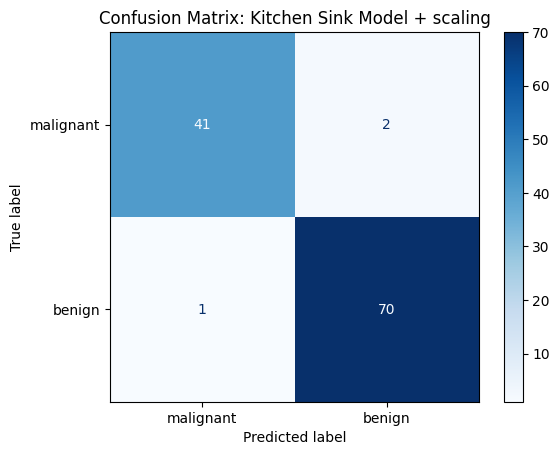

In [115]:
pipe = Pipeline(
    [
        (
            "preprocessor",
            ColumnTransformer(
                [
                    ("selected_features", StandardScaler(), importances.index),
                    #All features
                ]
            ),
        ),
        ("scaler", StandardScaler()),
        (
            "classifier",
            LogisticRegression(solver="saga", max_iter=1000, random_state=42),
        ),
    ]
)

pipe.fit(X_train, y_train)

pipe_train_accuracy = pipe.score(X_train, y_train)
pipe_accuracy = pipe.score(X_test, y_test)
print(f"Kitchen sink train accuracy: {pipe_train_accuracy:.3f}")
print(f"Kitchen sink test accuracy:  {pipe_accuracy:.3f}")

ConfusionMatrixDisplay.from_estimator(
    pipe, X_test, y_test, display_labels=cancer.target_names, cmap="Blues"
)
plt.title("Confusion Matrix: Kitchen Sink Model + scaling")
plt.show()

This produced good results on both the test and training data. It yielded better results than the kitchen sink approach without scaling. This approach can therefore be used, but it is important to check whether a simpler method with fewer parameters exists. It is desirable to perform as few measurements as possible (as measurements cost time and money), and we can therefore use the parameters identified in the EDA as the most suitable for determining **target**'s value.


We tested different numbers of parameters by removing and adding parameters from the list obtained from the **RandomForestClassification**. The code below uses SAGA scaling, and the four highest-ranked parameters to determine the target according to the **RandomForestClassification**.

Kitchen sink train accuracy: 0.943
Kitchen sink test accuracy:  0.974


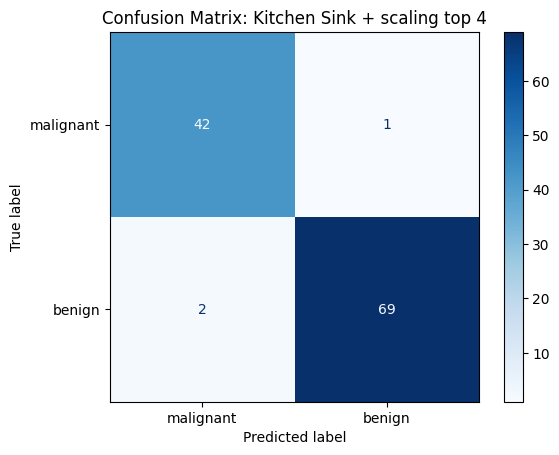

In [116]:
pipe = Pipeline(
    [
        (
            "preprocessor",
            ColumnTransformer(
                [
                    ("selected_features", StandardScaler(), importance_10_ind[0:4]),
                    #Velger top 4 fra random forest
                ]
            ),
        ),
        ("scaler", StandardScaler()),
        ("pca", PCA(n_components=1)),
        (
            "classifier",
            LogisticRegression(solver="saga", max_iter=1000, random_state=42),
        ),
    ]
)

pipe.fit(X_train, y_train)

pipe_train_accuracy = pipe.score(X_train, y_train)
pipe_accuracy = pipe.score(X_test, y_test)
print(f"Kitchen sink train accuracy: {pipe_train_accuracy:.3f}")
print(f"Kitchen sink test accuracy:  {pipe_accuracy:.3f}")

ConfusionMatrixDisplay.from_estimator(
    pipe, X_test, y_test, display_labels=cancer.target_names, cmap="Blues"
)
plt.title("Confusion Matrix: Kitchen Sink + scaling top 4")
plt.show()

In this result, we achieve a similarly good error margin on the test outcomes. We also see fewer cases where one thinks there is no cancer while there actually is (false negatives). This matters because false negatives are worse than the opposite (false positives). In a medical context, it is preferable that a patient is misdiagnosed in cases where they do not have cancer than in cases where they do have cancer. In addition, fewer tests are required since only 4 features are used, making the approach more efficient. It can therefore be described as a better model. One important point to acknowledge is that it achieves worse results on the training data, but this is not necessarily critical since performance on the test data is what matters most.

### Gradient Boosting Classifier

**Gradient Boosting** is a machine learning method that combines many small decision trees into a powerful model. Unlike training all trees simultaneously (like Random Forest), Gradient Boosting builds trees one at a time, where each new tree attempts to correct the errors from the previous one.

**Why use Gradient Boosting?**

- No need for manual feature selection — the model automatically finds the most important variables
- Handles complex relationships between features
- Works well with raw data, requires little preprocessing
- Provides information about which features are most important

This makes the method useful when you want strong performance without extensive upfront data preprocessing.

Gradient Boosting train accuracy: 1.000
Gradient Boosting test accuracy:  0.965


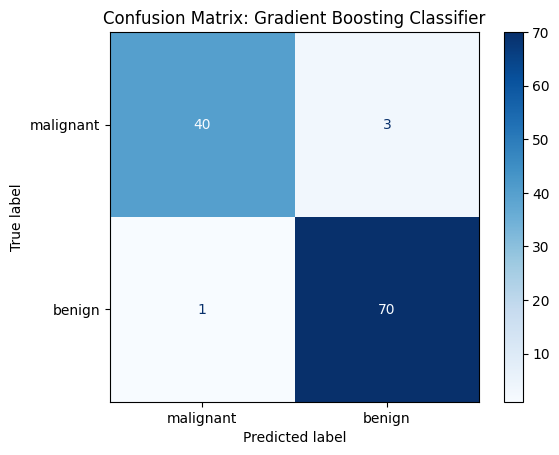

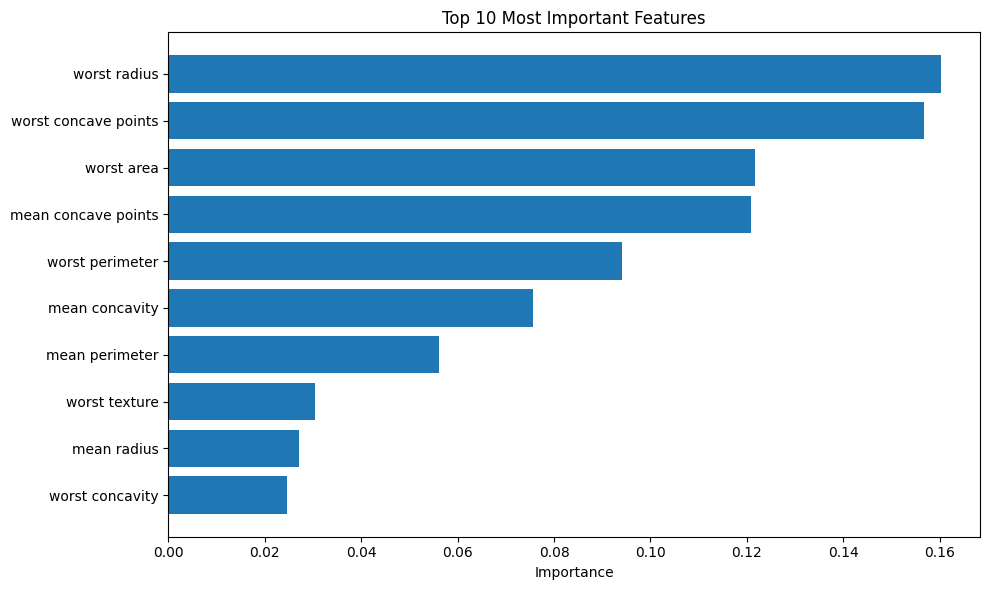

In [117]:
from sklearn.ensemble import GradientBoostingClassifier

gbc = GradientBoostingClassifier(
    n_estimators=300, learning_rate=0.05, random_state=100, max_features=5
)

gbc.fit(X_train, y_train)

pred_y = gbc.predict(X_test)


# Calculate accuracies
train_acc = gbc.score(X_train, y_train)
test_acc = accuracy_score(y_test, pred_y)

# Print accuracies
print(f"Gradient Boosting train accuracy: {train_acc:.3f}")
print(f"Gradient Boosting test accuracy:  {test_acc:.3f}")

# Display confusion matrix
ConfusionMatrixDisplay.from_estimator(
    gbc, X_test, y_test, display_labels=["malignant", "benign"], cmap="Blues"
)
plt.title("Confusion Matrix: Gradient Boosting Classifier")
plt.show()

# Print most important features
feature_importance = gbc.feature_importances_
feature_names = (
    X_train.columns
    if hasattr(X_train, "columns")
    else [f"Feature {i}" for i in range(X_train.shape[1])]
)

# Create a dataframe for better visualization
importance_df = pd.DataFrame(
    {"Feature": feature_names, "Importance": feature_importance}
).sort_values("Importance", ascending=False)


# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(importance_df["Feature"][:10], importance_df["Importance"][:10])
plt.xlabel("Importance")
plt.title("Top 10 Most Important Features")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

#### Conclusion

The Gradient Boosting model identifies many of the same important features that Random Forest found earlier in the EDA process. Both models highlight features such as **worst concave points**, **worst area/worst radius**, and **mean concave points** as key predictors for cancer classification, which validates our manual feature analysis.

Although Gradient Boosting achieves good performance without preprocessing, it does not perform as well as the pipeline model with preprocessing and the top 4 features from Random Forest. This demonstrates that while Gradient Boosting is robust and can handle raw data, the combination of feature selection, standardization, and a simpler model often produces better results. The preprocessing step reduces noise and allows the model to focus on the most informative variables, resulting in more stable predictions on test data.

It is also important to consider that the dataset is relatively small, and with larger datasets one could observe greater variation. This means our observations and our training might perform worse than other models. It is also important to acknowledge that there are numerous models for training that we have not used. It is realistic that one of these models could have produced better results.